## Заванння

## Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, date
import lifetimes as lt
from lifetimes.plotting import *
from lifetimes.utils import calibration_and_holdout_data

from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, CoxPHFitter

from sklearn.metrics import mean_absolute_error

from pycaret import regression as reg
from pycaret import clustering as clust

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_main = pd.ExcelFile("C:/Users/ASUS-X515EP/Downloads/Online Retail.xlsx").parse(0)
df_main = df_main.drop_duplicates()

In [3]:
# Ліквідую пусті значення про клєнтів, адже неможливо розрахувати адекватні значення LTV без під'вязки під конркретну особу
# а без знань, що за проудкт персона придбала - неможливо будувати адекватний basketing analysis
df_main = df_main[(~df_main['CustomerID'].isna())
                    & (~df_main.Description.isna())]
df_main.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
# Ці колонки відповідають за активність юзера в перший та останній місяць
df_main['First_Purch'] = df_main.groupby('CustomerID')['InvoiceDate'].transform('min')
df_main['Days_since_1M'] = (df_main['InvoiceDate'] - df_main['First_Purch']).dt.days
df_main['First_Month'] = df_main['Days_since_1M'].apply(lambda x: 1 if x<=30 else 0)
df_main = df_main.drop(['First_Purch', 'Days_since_1M'], axis=1)

df_main['Last_Purch'] = df_main.groupby('CustomerID')['InvoiceDate'].transform('max')
df_main['Days_since_LM'] = (df_main['Last_Purch'] - df_main['InvoiceDate']).dt.days
df_main['Last_Month'] = df_main['Days_since_LM'].apply(lambda x: 1 if x<=30 else 0)
df_main = df_main.drop(['Last_Purch', 'Days_since_LM'], axis=1)

In [5]:
countries = df_main.Country.value_counts().keys().to_list()

regions = {
    'Middle East': ['Israel', 'United Arab Emirates', 'Lebanon', 'Bahrain', 'Saudi Arabia'],
    'Europe': [
        'United Kingdom', 'Germany', 'France', 'EIRE', 'Spain', 'Netherlands',
        'Belgium', 'Switzerland', 'Portugal', 'Norway', 'Italy', 'Channel Islands',
        'Finland', 'Cyprus', 'Sweden', 'Austria', 'Denmark', 'Poland', 'Greece',
        'Malta', 'European Community', 'Lithuania', 'Czech Republic', 'Iceland'],
    'Asia': ['Japan', 'Hong Kong', 'Singapore'],
    'North America': ['USA', 'Canada'],
    'Oceania': ['Australia'],
    'Africa': ['RSA'],
    'South America': ['Brazil']
}

# Функція для пошуку регіону
def reg_func(x):
    for i, j in regions.items():
        if x in regions[i]:
            return i

df_main['Region'] = df_main['Country'].apply(reg_func)

In [6]:
df_main['Country'].value_counts(normalize=True).head(2)

Country
United Kingdom    0.888258
Germany           0.023605
Name: proportion, dtype: float64

In [7]:
df_main['TotalSum'] = np.round(df_main['Quantity'] * df_main['UnitPrice'], 2)

In [8]:
# Оскільки Африки та Південної Америки майже не усніє на записах - ці регіони я видалю.
# Ліквідувати викиди, які будуть заважати подальшій роботі.
df_main = df_main[(~df_main['Region'].isin(['Africa', 'South America'])) 
                    & (df_main.Country!='Unspecified') 
                    & (df_main['TotalSum'] > 0) & (df_main['TotalSum'] < 43) 
                    & (df_main['Quantity'] > 0) & (df_main['Quantity'] < 30) 
                 ]

In [9]:
# Змінюю тип даних
df_main['Country'] = df_main['Country'].astype('category')
df_main['Region'] = df_main['Region'].astype('category')

df_main['Description'] = df_main['Description'].astype('category')
df_main['StockCode'] = df_main['StockCode'].astype('category')
df_main['InvoiceDate'] = pd.to_datetime(df_main['InvoiceDate'])
df_main['Quantity'] = df_main['Quantity'].astype('int8')
df_main['UnitPrice'] = df_main['UnitPrice'].astype('float16')
df_main['TotalSum'] = df_main['TotalSum'].astype('float64')

df_main['InvoiceDate'] = df_main['InvoiceDate'].astype('datetime64[s]')

In [10]:
df_main.InvoiceDate = df_main.InvoiceDate.dt.strftime("%Y-%m-%d")
df_main.InvoiceDate = pd.to_datetime(df_main.InvoiceDate).astype('datetime64[s]')

In [11]:
max_date = df_main.InvoiceDate.max()

## Функції для роботи

### Створення нових DF для роботи

In [12]:
# Отрмую частину загального датафрейму певного регіону
def region_df(df_, region):
    df = df_.copy()
    df = df[df.Region==region]
    return df

In [13]:
def train_test(train):
    cutoff_date = pd.to_datetime("2011-09-01")
    end_date = pd.to_datetime("2011-12-01")
    
    df=train.copy()
    train_df = df[df['InvoiceDate']<cutoff_date]  
    test_df = df[(df['InvoiceDate']>=cutoff_date)
                   & (df['InvoiceDate']<end_date)]

    return train_df, test_df

In [14]:
# датафрейм для навчання регресійної моделі
def train_ml_(df_):
    df = df_.copy()
    cutoff_date = pd.to_datetime("2011-09-01")
    end_date = pd.to_datetime("2011-12-01")
    
    temp_in = df[df['InvoiceDate']<cutoff_date]
    
    
    # No data leakage!     
    temp_out = df[(df['InvoiceDate']>=cutoff_date)
                   & (df['InvoiceDate']<end_date)].query('CustomerID in @temp_in.CustomerID')
    
    label_df = (temp_out[['CustomerID', 'TotalSum']]
                .groupby('CustomerID', as_index=False)
                .TotalSum
                .sum()
                .rename({'TotalSum':'TotalSum_90'}, axis=1))    

    return temp_in, temp_out, label_df

### Когорти

In [15]:
# Функція для щомісячних когорт
def prune_month(x):
    return dt.datetime(x.year, x.month, 1)

def year_month(df_, col):
    df = df_
    year = df[col].dt.year
    month = df[col].dt.month
    return year, month


def cohort_month(df, region):
    df = region_df(df, region).copy()

    df['InvoiceMonth'] = df['InvoiceDate'].apply(prune_month)
    df['CohortMonth'] = df.groupby('CustomerID', observed=True)['InvoiceMonth'].transform('min')

    i_y, i_m = year_month(df, 'InvoiceDate')
    c_y, c_m = year_month(df, 'CohortMonth')

    year_diff = i_y - c_y
    month_diff = i_m - c_m
        
    df['MonthIndex'] = year_diff * 12 + month_diff + 1

    df_m = df.groupby(['MonthIndex', 'CohortMonth'],
                     as_index=False, observed=True)['CustomerID'].apply(pd.Series.nunique)

    cohort_m = df_m.pivot(
        index='CohortMonth',
        columns='MonthIndex',
        values='CustomerID')

    cohort_m.index = cohort_m.index.strftime('%Y-%m-%d')
    
    return (df, cohort_m)

In [16]:
# Візуалізація когорт
def viz_cohort(df):
    plt.figure(figsize=(15, 10))
    sns.set_style("white")
    sns.heatmap(df,
                annot=True,
                cmap='Blues',
                fmt='g')
    plt.show()

### Segmentation

In [99]:
# RFM сегментація клієнтів
def segmentation(df_, max_date):
    df = df_.copy()
    max_day = max_date
    df = df[df.InvoiceDate < max_day]
    
    df_rfmf = (df
               .groupby(['CustomerID', 'InvoiceNo'])
               .agg(
                   TotalSales=('TotalSum', 'sum'),
                   Timestamp=('InvoiceDate', 'max')
                   )
               .reset_index()
               .groupby('CustomerID')
               .agg(
                    Recency=('Timestamp', lambda x: (max_day - x.max()).days),
                    Frequency=('InvoiceNo', 'nunique'),
                    MonetaryValue_Sum=('TotalSales', 'sum'),
                    MonetaryValue_Mean=('TotalSales', 'mean'),
                    Tenure=('Timestamp', lambda x: (x.max() - x.min()).days)
                    )
               .reset_index()
              )
    
    df_rfmf['Churned'] = df_rfmf.apply(lambda row: 1 if ((row['Recency'] >= 180) | ((row['Recency'] >= 150) and (row['Frequency'] =< 2))) else 0, axis=1)
    
    df_rfmf['TenureMonth'] = df_rfmf['Tenure'] // 30
    df_rfmf['TenureMonth'] = df_rfmf['TenureMonth'].astype('int')
    
    # беремо до уваги тільки тих, хто приносить позитивний дохід і тих, хто зробив хоч одну покупку
    df_rfmf = df_rfmf[(df_rfmf['MonetaryValue_Sum']>0) & (df_rfmf['Frequency']>0)]

    return df_rfmf

SyntaxError: invalid syntax (2012044972.py, line 25)

### Survival analysis

In [19]:
# Найкраща "Survival fucntion"
def best_fit_surv_model(surv_df, life, observed):
    df = surv_df.copy()

    # Нульові значення життя модель не обробляє
    df[life] += 0.001
    
    wb = WeibullFitter()
    wb.fit(durations=df[life], event_observed=df[observed])
    
    ef = ExponentialFitter()
    ef.fit(durations=df[life], event_observed=df[observed])
    
    ln = LogNormalFitter()
    ln.fit(durations=df[life], event_observed=df[observed])
    
    ll = LogLogisticFitter()
    ll.fit(durations=df[life], event_observed=df[observed])

    models = {
            'WeibullFitter': wb.AIC_,
            'ExponentialFitter': ef.AIC_,
            'LogNormalFitter': ln.AIC_,
            'LogLogisticFitter': ll.AIC_
             }

    best_model = min(models, key=models.get)
    
    return best_model

In [20]:
def surv_model(model_):
    fig, ax = plt.subplots()
    df1 = surv_df.copy()
    df = df1.copy()
    # Нульові значення життя модель не обробляє
    df['Tenure'] += 0.001
    model = model_
    model.fit(
        durations=df['Tenure'],
        event_observed=df['Churned']
    )
    model.plot_survival_function(ax=ax)
    plt.show()

    return model    

### LTV

#### Agg

In [21]:
def agg_ltv(df_, region):
    seg_df = df_
    if region == 'Europe':
        dict = {'avg_sales': seg_df['MonetaryValue_Mean'].mean(),
                 'avg_freq': seg_df['Frequency'].mean(),
                 'churn_rate': seg_df[((seg_df['Frequency']<=2) & (seg_df['Recency']>=150)) | (seg_df['Recency']>180)].shape[0] / len(seg_df['Recency']),
                 'max_days': seg_df['Tenure'].max()}
    else:
        dict = {'avg_sales': seg_df['MonetaryValue_Mean'].mean(),
                 'avg_freq': seg_df['Frequency'].mean(),
                 'churn_rate': seg_df[(seg_df['Frequency']<=1) | (seg_df['Recency']>90)].shape[0] / len(seg_df['Recency']),
                 'max_days': seg_df['Tenure'].max()}

    churn_ltv = (dict['avg_sales'] * dict['avg_freq']) / dict['churn_rate'] 
    return churn_ltv

#### Cohort

In [22]:
def cohort_ltv(df_):
    df = df_.copy()
    
    df['Start_month'] = df.groupby('CustomerID')['InvoiceDate'].transform(lambda x: x.min().strftime('%Y-%m'))
    
    df = (df
            .groupby(['Start_month', 'CustomerID', 'InvoiceNo'])
            .agg(
               total_sales=('TotalSum', 'sum'),
               InvoiceDate=('InvoiceDate', 'max')
               )
            .reset_index()
            .groupby(['Start_month', 'CustomerID'])
            .agg(
               Recency=('InvoiceDate', lambda x: (max_date-x.max()).days),
               Frequency=('InvoiceNo', 'nunique'),
               MonetaryValue=('total_sales', 'sum'),
               Mean_MV=('total_sales', 'mean'),
               Tenure=('InvoiceDate', lambda x: (x.max() - x.min()).days)
               )
            .reset_index()
         )

    df_cohort_sum = (df
                     .groupby('Start_month', as_index=False)
                     .agg(
                         cohort_size=('CustomerID', 'nunique'),
                         avg_sales=('Mean_MV', 'mean'),
                         avg_freq=('Frequency', 'mean'),
                         max_day=('Tenure', 'max'),
                         churn_rate=('Recency', lambda x: (x>90).sum() / len(x)),
                         )
                     )

    df_cohort_sum['LTV'] = (df_cohort_sum['avg_sales'] * df_cohort_sum['avg_freq']) / (df_cohort_sum['churn_rate'])

    # Оскільки багато людей в нових когортах не встигли перейти в касту "churn", тому що їх "вік" цього ще не дозволяє - я їх викину.
    # Але, для нових юзерів можна застосувати Survival Analysis.
    ret_df = df_cohort_sum.iloc[:9, :]
    
    
    return ret_df

In [23]:
def LTV_coh(df_):
    df = df_.copy()
    df_coh_al = cohort_ltv(df).copy()
    df_coh_al['prop_size'] = df_coh_al['cohort_size'] /  df_coh_al['cohort_size'].sum()
    df_coh_al['LTV_prop'] = df_coh_al['LTV'] * df_coh_al['prop_size']
    return df_coh_al['LTV_prop'].sum()

#### Prob

In [24]:
def prob_LTV(prob_df, bgf_, gg_):
    # Інфляція в доларах - 3.36%
    # https://ycharts.com/indicators/us_inflation_rate#:~:text=Basic%20Info,in%20price%20over%20a%20year.
    for i in range(1, 5):
        prob_df[f'CLV_{i}month'] = gg_.customer_lifetime_value(
            bgf_,
            prob_df['frequency'],
            prob_df['recency'],
            prob_df['T'],
            prob_df['monetary_value'],
            time=i,
            discount_rate=0.0336
            ) + prob_df['frequency'] * prob_df['monetary_value'] # LTV = теперішні доходи + майбутні 

    return prob_df

In [25]:
def plot_din(prob_df):
    fig, ax = plt.subplots()
    plt.figure(figsize=(6, 6))
    
    x = np.arange(1, 5)
    y = prob_df[['CLV_1month', 'CLV_2month', 'CLV_3month', 'CLV_4month']].median().to_list()
    
    g = sns.lineplot(x=x,
                     y=y, 
                     ax=ax)

    g.set_title("Медіанна динаміка LTV протягом наступних 4 місяців")

    g.set(xlabel='Місяць',
          ylabel='$')
    plt.show()
    plt.close(fig)

#### Survival

In [176]:
def surv_LTV(df):
      # середній прибуток на одного клієнта в місяць
    avg_cust_rev = (df_eu.resample('M', on='InvoiceDate').TotalSum.sum() / df_eu.resample('M', on='InvoiceDate').CustomerID.nunique()).mean() * 0.916
    surv_df = df.copy()
    
    surv_df = (pd
             .concat([pd.DataFrame([1.00]), log.survival_function_at_times(range(1, 29))])
             .rename(columns={0: 'Survival Probability'}))
    
    surv_df['Month'] = surv_df.index.astype('int')
    surv_df['Monthly Revenue'] = avg_cust_rev   
    surv_df['Avg Expected Monthly Revenue'] = np.round(surv_df['Survival Probability'] * surv_df['Monthly Revenue'], 2)
    
    surv_df['Cumulative Revenue (LTV)'] = surv_df['Avg Expected Monthly Revenue'].cumsum()
    surv_df['Month'] += 1
    
    return surv_df.set_index('Month').reset_index().iloc[:, :]

### ML segmentation and feature engineering

In [27]:
def ml_segmentation(df, cutoff_date):

    temp_in = df[df.InvoiceDate <= cutoff_date].copy()
    
    # Кількість транзакцій у перший місяць
    t30 = (
        temp_in[['CustomerID', 'InvoiceNo']][temp_in['First_Month']==1]
        .groupby('CustomerID')
        .InvoiceNo
        .nunique()
        .to_frame()
        .set_axis(['t30'], axis=1)
       )

    # Об'єм продаж у перший місяць
    s30 = (
            temp_in[['CustomerID', 'TotalSum']][temp_in['First_Month']==1]
            .groupby('CustomerID')
            .TotalSum
            .sum()
            .to_frame()
            .set_axis(['s30'], axis=1)
            )


    # Кількість транзакцій в останній місяць  
    lt30 = (
        temp_in[['CustomerID', 'InvoiceNo']][temp_in['Last_Month']==1]
        .groupby('CustomerID')
        .InvoiceNo
        .nunique()
        .to_frame()
        .set_axis(['lt30'], axis=1)
       )


    # Об'єм продаж в останній місяць
    ls30 = (
            temp_in[['CustomerID', 'TotalSum']][temp_in['Last_Month']==1]
            .groupby('CustomerID')
            .TotalSum
            .sum()
            .to_frame()
            .set_axis(['ls30'], axis=1)
            )
    

    train_df_ = pd.concat([t30, s30, lt30, ls30], axis=1).reset_index()
    
    
    features_in = (temp_in
                   .groupby('CustomerID')
                   .agg(
                        first_purchase_date=('InvoiceDate', 'min'),
                        last_purchase_date=('InvoiceDate', 'max')
                        )
                   .reset_index()
                  )
    
    # сегментація
    add_features_in = segmentation(temp_in, cutoff_date)
    
    
    train_df = features_in.merge(
                    add_features_in,
                    on='CustomerID'
                    )
    
    
    train_df['days_since_first_purchase'] = (cutoff_date - train_df['first_purchase_date']).dt.days
    train_df['days_between_purchases'] = (train_df['last_purchase_date'] - train_df['first_purchase_date']).dt.days \
                                                / train_df['Frequency']
    train_df.drop(['first_purchase_date', 'last_purchase_date', "days_since_first_purchase"], axis=1, inplace=True)

    
    train_df = train_df.merge(train_df_,
                             on='CustomerID').fillna(0)
    
    
    return train_df

### Кластеризація

In [28]:
# Середні значення для кожного з класетрів
def clust_segm(df):
    df_cl = df.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue_Sum': 'mean',
        'Pred_90D': 'mean',
        'Tenure': ['mean', 'count']
      }).round(1)
    
    df_cl.columns = ['_'.join(col).strip() for col in df_cl.columns.values]

    df_cl.rename(columns={'Recency_mean': 'Recency',
                             'Frequency_mean': 'Frequency',
                             'MonetaryValue_mean': 'MonetaryValue',
                             'Tenure_mean': 'Tenure',
                             'Tenure_count': 'Customers'}, inplace=True)

    return df_cl

## Europe

### Dataset

In [29]:
df_eu = region_df(df_main, 'Europe')
df_eu.sample(2)

InvoiceNo StockCode                  Description  Quantity InvoiceDate  \
205550    554817     23170     REGENCY TEA PLATE ROSES         12  2011-05-26   
399096    571270     21619  4 VANILLA BOTANICAL CANDLES         3  2011-10-16   

        UnitPrice  CustomerID         Country  First_Month  Last_Month  \
205550   1.650391     15622.0  United Kingdom            0           0   
399096   1.250000     12940.0  United Kingdom            0           1   

        Region  TotalSum  
205550  Europe     19.80  
399096  Europe      3.75

### Cohort

In [30]:
pivot_eu = cohort_month(df_main, 'Europe')[1]
pivot_eu.head(1)

MonthIndex      1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   820.0  295.0  251.0  300.0  287.0  319.0  295.0  269.0  274.0   

MonthIndex      10     11     12     13  
CohortMonth                              
2010-12-01   309.0  295.0  406.0  209.0

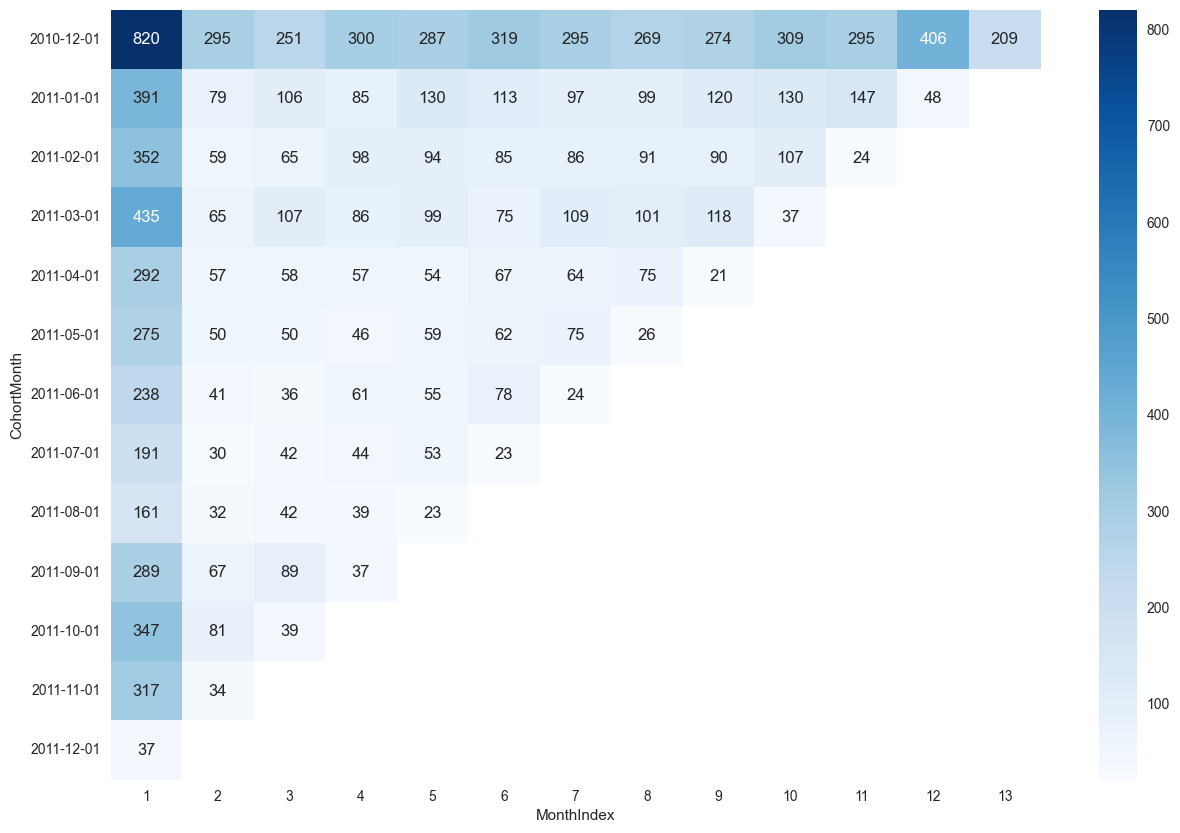

In [31]:
viz_cohort(pivot_eu)

In [32]:
users = pivot_eu.iloc[1:, 0].mean()
print(f'Середня кількість користувачів, які приєднуються кожного місяця {users:.0f}.')

Середня кількість користувачів, які приєднуються кожного місяця 277.


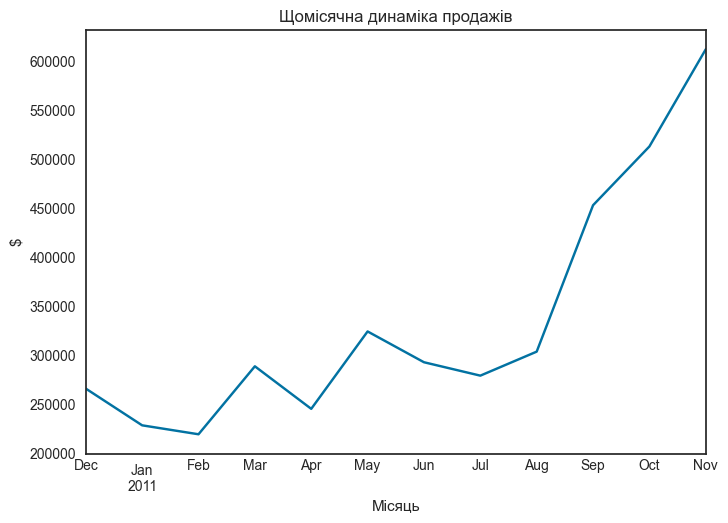

In [33]:
df_main.resample('M', on='InvoiceDate').TotalSum.sum().iloc[:-1].plot(grid=False)
plt.xlabel("Місяць")
plt.ylabel("$")
plt.title("Щомісячна динаміка продажів")
plt.show()

### Segmentation

In [147]:
seg_eu = segmentation(df_eu, max_date)
seg_eu.sample(2)

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  \
983      13767.0        2         36            5678.86          157.746111   
3760     17718.0      232          1             139.35          139.350000   

      Tenure  Churned  TenureMonth  
983      371        0           12  
3760       0        1            0

### Survival analysis

In [101]:
surv_df = seg_eu.copy()
surv_df.sample(5)

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  \
3440     17263.0      208          1              63.44           63.440000   
3854     17863.0       59          6            2419.12          403.186667   
511      13089.0        4         79           28337.48          358.702278   
2376     15746.0      134          1             182.96          182.960000   
1604     14651.0       67          2             653.75          326.875000   

      Tenure  Churned  TenureMonth  
3440       0        1            0  
3854     310        0           10  
511      364        0           12  
2376       0        0            0  
1604     144        0            4

In [102]:
surv_model = best_fit_surv_model(surv_train_eu, 'TenureMonth', 'Churned')
surv_model

'LogNormalFitter'

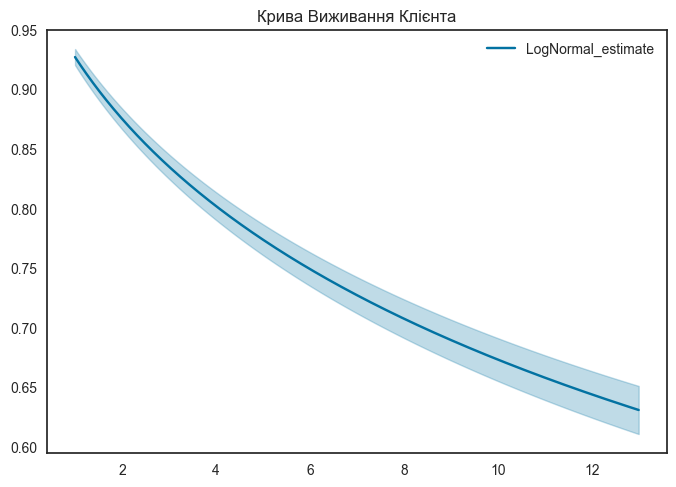

In [128]:
import lifelines
df = seg_eu.copy()

# Нульові значення "життя" модель не обробляє
df['TenureMonth'] += 1

log = lifelines.LogNormalFitter()
log.fit(
    durations=df['TenureMonth'],
    event_observed=df['Churned']
)

fig, ax = plt.subplots()
log.plot_survival_function(ax=ax)
ax.set_title("Крива Виживання Клієнта")
plt.show()

In [137]:
log.predict(28)
# Середеній період життя клієнта складає 28-29 місяців.

0.4993981070208203

In [177]:
# LTV на кожному кроці життя
suvr_eu_LTV = surv_LTV(seg_eu)
suvr_eu_LTV

Month  Survival Probability  Monthly Revenue  \
0       1              1.000000       305.743305   
1       2              0.927166       305.743305   
2       3              0.875345       305.743305   
3       4              0.835170       305.743305   
4       5              0.802074       305.743305   
5       6              0.773829       305.743305   
6       7              0.749152       305.743305   
7       8              0.727225       305.743305   
8       9              0.707493       305.743305   
9      10              0.689556       305.743305   
10     11              0.673118       305.743305   
11     12              0.657952       305.743305   
12     13              0.643879       305.743305   
13     14              0.630757       305.743305   
14     15              0.618471       305.743305   
15     16              0.606924       305.743305   
16     17              0.596036       305.743305   
17     18              0.585740       305.743305   
18     19              0.575979       305.743305   
19     20              0.566702       305.743305   
20     21              0.557867       305.743305   
21     22              0.549436       305.743305   
22     23              0.541377       305.743305   
23     24              0.533660       305.743305   
24     25              0.526260       305.743305   
25     26              0.519153       305.743305   
26     27              0.512319       305.743305   
27     28              0.505740       305.743305   
28     29              0.499398       305.743305   

    Avg Expected Monthly Revenue  Cumulative Revenue (LTV)  
0                         305.74                    305.74  
1                         283.47                    589.21  
2                         267.63                    856.84  
3                         255.35                   1112.19  
4                         245.23                   1357.42  
5                         236.59                   1594.01  
6                         229.05                   1823.06  
7                         222.34                   2045.40  
8                         216.31                   2261.71  
9                         210.83                   2472.54  
10                        205.80                   2678.34  
11                        201.16                   2879.50  
12                        196.86                   3076.36  
13                        192.85                   3269.21  
14                        189.09                   3458.30  
15                        185.56                   3643.86  
16                        182.23                   3826.09  
17                        179.09                   4005.18  
18                        176.10                   4181.28  
19                        173.27                   4354.55  
20                        170.56                   4525.11  
21                        167.99                   4693.10  
22                        165.52                   4858.62  
23                        163.16                   5021.78  
24                        160.90                   5182.68  
25                        158.73                   5341.41  
26                        156.64                   5498.05  
27                        154.63                   5652.68  
28                        152.69                   5805.37

### Churn

In [186]:
# Для останніх 5 місяців багато клієнтів не здатні виконувати умов для того, щоб бути "churn",
# тому що їх "життя" з нами занадто мале - я не буду їх враховувати при разрахунку цього параметру, 
# аби не робити оцінку розмазаною.
df_surv = df_eu[df_eu['InvoiceDate'] < '2011-07-01']
seg_surv = seg_eu.query('CustomerID in @df_surv.CustomerID')

overall_churn = np.round(seg_surv.Churned.mean() * 100, 2)
print(f"Загальний Churn: {overall_churn:.2f}%")

Загальний Churn: 31.18%


### LTV Probability Implementation

In [456]:
# Розділяю на тестову та навчальну вибірки.
rfm_cal_holdout = calibration_and_holdout_data(transactions=df_eu,
                                               customer_id_col='CustomerID', 
                                               datetime_col='InvoiceDate',
                                               monetary_value_col = 'TotalSum',
                                               freq='D',
                                               calibration_period_end=pd.to_datetime('2011-09-01'),
                                               observation_period_end=pd.to_datetime('2011-12-01'))

In [457]:
# Прогнозує ймовірність його Churn та кількість майбутніх транзакцій
bgf = lt.ModifiedBetaGeoFitter(penalizer_coef=0.00003)

# Моделювання активності юзера.
# fitting of BG-NBD model
model = bgf.fit(frequency=rfm_cal_holdout['frequency_cal'], 
                recency=rfm_cal_holdout['recency_cal'], 
                T=rfm_cal_holdout['T_cal'])

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

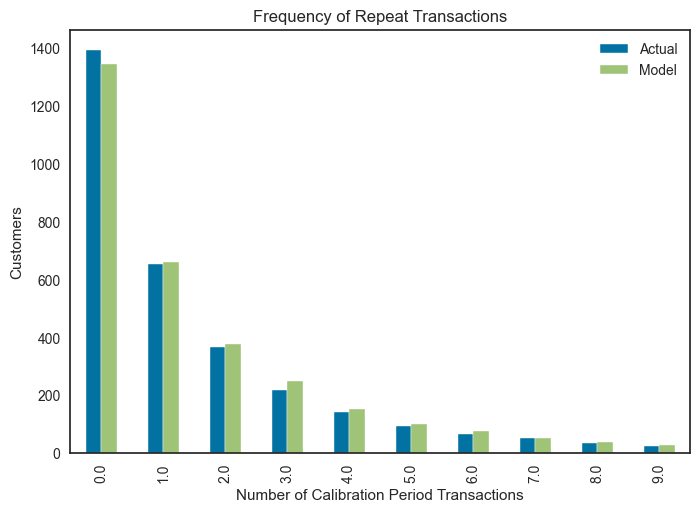

In [458]:
lt.plotting.plot_period_transactions(bgf, max_frequency=10) 

Модель відносно реальних даних виглядає адекватно

In [459]:
# реальна кількість транзакцій за період спостереження, яка дорівнює frequency_holdout + 1
rfm_cal_holdout["n_transactions_holdout_real"]  = rfm_cal_holdout["frequency_holdout"] + 1

# прогнозована кількість транзакцій протягом наступних 13 тижнів (тривалість періоду спостереження)
rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=rfm_cal_holdout['duration_holdout'],
                                                              frequency=rfm_cal_holdout['frequency_cal'], 
                                                              recency=rfm_cal_holdout['recency_cal'], 
                                                              T=rfm_cal_holdout['T_cal'])

# порівняння реальних і прогнозованих операцій
rfm_cal_holdout = rfm_cal_holdout.replace([np.inf, np.NaN], 0)
rfm_cal_holdout[["n_transactions_holdout_real", "n_transactions_holdout_pred"]].sample(5)

n_transactions_holdout_real  n_transactions_holdout_pred
CustomerID                                                          
15717.0                             1.0                     0.324975
13023.0                             2.0                     0.662050
17589.0                             2.0                     1.173344
17611.0                             5.0                     2.385792
17584.0                             1.0                     0.675393

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

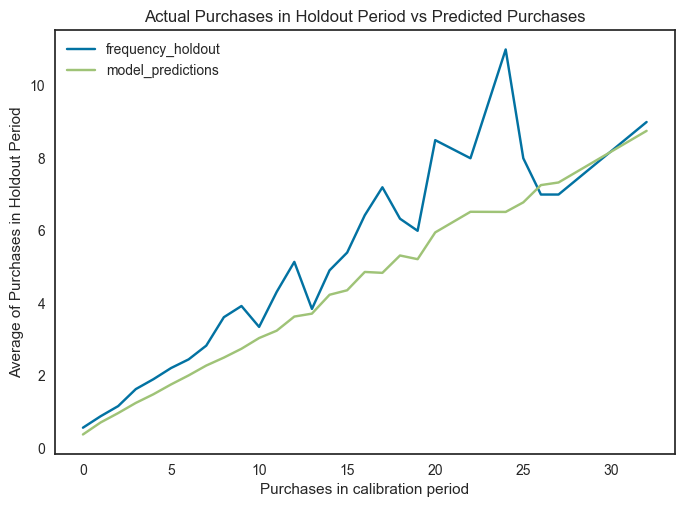

In [460]:
plot_calibration_purchases_vs_holdout_purchases(bgf,
                                               rfm_cal_holdout,
                                               n=27)

In [461]:
MSE = mean_absolute_error(y_true = rfm_cal_holdout["n_transactions_holdout_real"],
                          y_pred = rfm_cal_holdout["n_transactions_holdout_pred"])
print(f'В середньому, прогнозована кількость транзакцій буде відхилятися на {MSE:.2f} транзакції.')

В середньому, прогнозована кількость транзакцій буде відхилятися на 1.36 транзакції.


In [462]:
rfm_cal_holdout['expected_purc_4_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(120, 
                                                                                               rfm_cal_holdout['frequency_cal'], 
                                                                                               rfm_cal_holdout['recency_cal'], 
                                                                                               rfm_cal_holdout['T_cal'])

In [463]:
# Gamma-gamma model
# Розрахунок фінансової частини LTV.
clv_gg = lt.utils.summary_data_from_transaction_data(df_eu,
                                                     'CustomerID',
                                                     'InvoiceDate',
                                                     'TotalSum',
                                                     observation_period_end='2011-09-01')
clv_gg = clv_gg[clv_gg['monetary_value'] > 0]
clv_gg.sample(2)

frequency  recency      T  monetary_value
CustomerID                                           
16010.0           2.0    117.0  263.0         141.150
16317.0           2.0    178.0  198.0         340.385

In [464]:
# Не повинна бути присутня кореляція між цими факторами для подальшої роботи з Gamma-Gamma
clv_gg[['frequency','monetary_value']].corr()

frequency  monetary_value
frequency        1.000000       -0.016437
monetary_value  -0.016437        1.000000

In [465]:
# Прогнозує, скільки грошей в середньому будемо заробляти з однієї транзакції
gg = lt.GammaGammaFitter(penalizer_coef=0.005)

gg.fit(clv_gg['frequency'],
       clv_gg['monetary_value'])

clv_gg['exp_mon'] = gg.conditional_expected_average_profit(clv_gg['frequency'],
                                                           clv_gg['monetary_value'])
clv_gg.sample(2)

frequency  recency      T  monetary_value     exp_mon
CustomerID                                                       
17795.0           1.0     85.0  165.0         180.300  204.479390
16725.0           5.0     69.0  272.0         127.224  130.693133

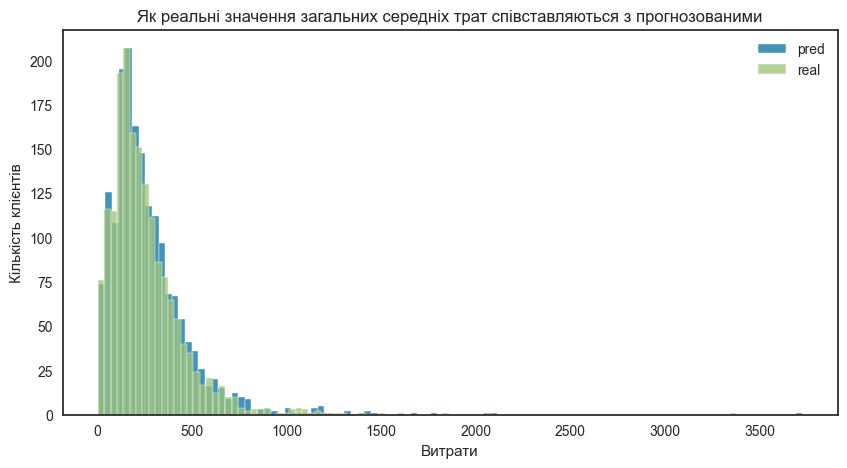

In [466]:
# Як реальні значення загальних середніх трат співставляються з прогнозованими
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(clv_gg['exp_mon'], ax=ax, label='pred')
sns.histplot(clv_gg['monetary_value'], ax=ax, label='real')
ax.set_xlabel("Витрати")
ax.set_ylabel("Кількість клієнтів")
ax.set_title("Як реальні значення загальних середніх трат співставляються з прогнозованими")
plt.legend()

#### Оцінка точності цієї моделі

In [467]:
# Train/test split
train_eu_prob, test_eu_prob = train_test(df_eu)

In [468]:
train_rfm = lt.utils.summary_data_from_transaction_data(
    train_eu_prob,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalSum',
    observation_period_end=pd.to_datetime('2011-09-01'),
    freq='D'
)
# Для Gamma-Gamma моделей значення "monetary_value" мають бути додатніми.
train_rfm = train_rfm[train_rfm['monetary_value']>0].reset_index()

test_rfm = lt.utils.summary_data_from_transaction_data(
    test_eu_prob,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalSum',
    observation_period_end=pd.to_datetime('2011-12-01'),
    freq='D'
)
# Для Gamma-Gamma моделей значення "monetary_value" мають бути додатніми.
test_rfm = test_rfm[test_rfm['monetary_value']>0].reset_index()

In [469]:
# Скільки грошей за наступні 3 місяці принесе клієнт за розрахунками моделі.
train_rfm[f'CLV_3month'] = gg.customer_lifetime_value(
            bgf,
            train_rfm['frequency'],
            train_rfm['recency'],
            train_rfm['T'],
            train_rfm['monetary_value'],
            time=3,
            discount_rate=0.0336)

# Скільки грошей приніс клієнт за наступні 3 місяці реально.
test_rfm['m3_value'] = test_rfm['frequency'] * test_rfm['monetary_value']

check_df = train_rfm.merge(test_rfm[['CustomerID', 'm3_value']], 
                          on='CustomerID')
check_df.head()

CustomerID  frequency  recency      T  monetary_value  CLV_3month  m3_value
0     12352.0        3.0     34.0  197.0      141.670000  173.727863    497.98
1     12362.0        3.0    175.0  196.0      390.230000  476.596931   1712.55
2     12395.0        7.0    259.0  272.0      166.844286  322.621323    712.98
3     12408.0        1.0     85.0  161.0      430.920000  302.901753    218.88
4     12433.0        1.0      7.0  274.0     1180.720000  554.032827   1404.66

In [470]:
# Розраховую похибку моделі
mae = np.round(mean_absolute_error(check_df['CLV_3month'], check_df['m3_value']))
print(f'Похибка моделі складає: {mae:.2f}$')

Похибка моделі складає: 366.00$


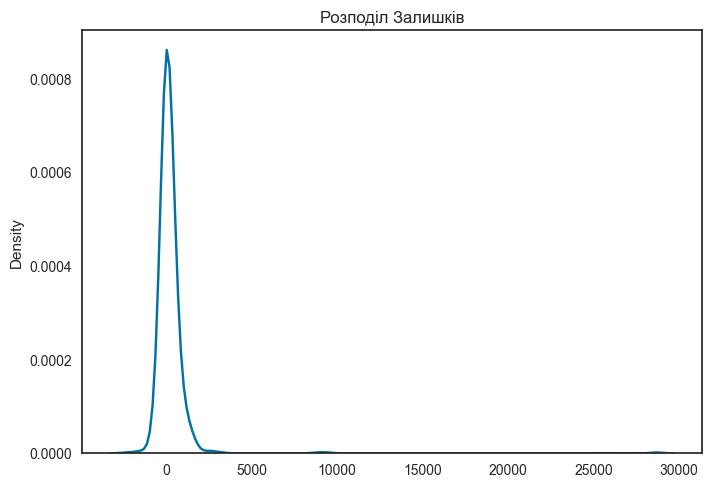

In [471]:
error = check_df['m3_value'] - check_df['CLV_3month']
sns.kdeplot(error)
plt.title("Розподіл Залишків")
plt.show()

(0.0, 7000.0)

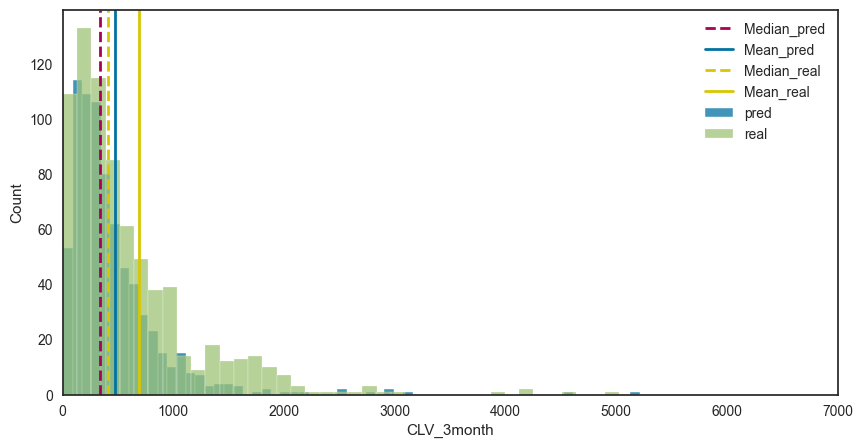

In [472]:
# Як реальні значення загальних середніх трат співставляються з прогнозованими
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(check_df['CLV_3month'], ax=ax, label='pred')
sns.histplot(check_df['m3_value'], ax=ax, label='real')

ax.axvline(x=check_df['CLV_3month'].median(), color='m', label='Median_pred', linestyle='--', linewidth=2)
ax.axvline(x=check_df['CLV_3month'].mean(), color='b', label='Mean_pred', linestyle='-', linewidth=2)

ax.axvline(x=check_df['m3_value'].median(), color='y', label='Median_real', linestyle='--', linewidth=2)
ax.axvline(x=check_df['m3_value'].mean(), color='y', label='Mean_real', linestyle='-', linewidth=2)

plt.legend()
plt.xlim([0, 7000])

In [473]:
# Оскліьки модель недооцінює майбутню кількість транзакцій, враховувти факт того, 
# скільки відсотків товарів нам поверають - не має сенсу.

#### Прогнози

In [474]:
prob_eu = lt.utils.summary_data_from_transaction_data(
    df_eu,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalSum',
    observation_period_end=pd.to_datetime('2011-12-01'),
    freq='D'
)

# Для Gamma-Gamma моделей значення "monetary_value" мають бути додатніми.
prob_eu = prob_eu[prob_eu['monetary_value']>0]
prob_eu.head()

frequency  recency      T  monetary_value
CustomerID                                           
12347.0           5.0    328.0  359.0      469.994000
12348.0           3.0    283.0  350.0       52.466667
12352.0           6.0    260.0  288.0      201.540000
12356.0           2.0    303.0  317.0      163.105000
12359.0           3.0    274.0  323.0     1361.710000

In [475]:
# Прогнози того, скільки принесе клієнт у наступні 4 місяці в деталях.
prob_eu_ = prob_LTV(prob_eu, bgf, gg).reset_index()

prob_eu_.sample(5)

CustomerID  frequency  recency      T  monetary_value   CLV_1month  \
2038     17049.0        6.0    254.0  267.0        682.1550  4493.966020   
1438     15660.0        5.0    340.0  357.0        242.8080  1310.642910   
504      13536.0        4.0     66.0   67.0        318.7175  1600.692255   
493      13515.0        3.0    175.0  239.0        229.2400   771.040743   
1499     15804.0       11.0    187.0  190.0        278.1800  3426.437110   

       CLV_2month   CLV_3month   CLV_4month  
2038  4881.965266  5257.351532  5620.534840  
1438  1404.105478  1494.529789  1582.014610  
504   1915.922764  2220.905842  2515.974610  
493    851.652918   929.644573  1005.100895  
1499  3780.981528  4124.000509  4455.868717

### ML :)

In [301]:
train_ml, test_ml, label_ml = train_ml_(df_eu)
train_ml.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  First_Month  Last_Month  \
0  2010-12-01   2.550781     17850.0  United Kingdom            1           0   
1  2010-12-01   3.390625     17850.0  United Kingdom            1           0   
2  2010-12-01   2.750000     17850.0  United Kingdom            1           0   
3  2010-12-01   3.390625     17850.0  United Kingdom            1           0   
4  2010-12-01   3.390625     17850.0  United Kingdom            1           0   

   Region  TotalSum  
0  Europe     15.30  
1  Europe     20.34  
2  Europe     22.00  
3  Europe     20.34  
4  Europe     20.34

In [295]:
train = ml_segmentation(train_ml, pd.to_datetime('2011-09-01'))
train = train.merge(label_ml, 
                   on='CustomerID',
                   how='left').fillna(0)
train.shape

(3070, 14)

In [296]:
train.sample(5)

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  \
1327     14862.0       49          1             265.54              265.54   
1833     15847.0      189          1             120.20              120.20   
2683     17542.0      170          1             170.75              170.75   
2508     17173.0       17          2             404.46              202.23   
2862     17871.0      105          1             131.42              131.42   

      Tenure  Churned  TenureMonth  days_between_purchases  t30     s30  lt30  \
1327       0        0            0                     0.0  1.0  265.54   0.0   
1833       0        1            0                     0.0  1.0  120.20   0.0   
2683       0        1            0                     0.0  1.0  170.75   1.0   
2508      15        0            0                     7.5  2.0  404.46   0.0   
2862       0        0            0                     0.0  1.0  131.42   1.0   

        ls30  TotalSum_90  
1327    0.00       518.38  
1833    0.00       208.59  
2683  170.75         0.00  
2508    0.00       613.14  
2862  131.42         0.00

In [ ]:
reg_setup = reg.setup(
        data=train,
        target='TotalSum_90',
        ignore_features=['CustomerID', "s30", "t30"],
        use_gpu=True,
        n_jobs=-1,
        session_id=954121010,
        fold_shuffle=True,
        fold=5,
)

In [305]:
model = reg.compare_models(turbo=True,
                            exclude=['catboost'])

In [ ]:
model = reg.tune_model(
    estimator=model,
    n_iter=500,
    search_library='optuna', 
    search_algorithm='tpe',
    verbose=False,
    tuner_verbose=True,
    optimize='R2',
    choose_better=True)
model

In [414]:
reg.pull()

MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     202.4729  129675.0116  360.1042  0.5484  2.6568  0.8321
1     207.2372  218851.3972  467.8156  0.6812  2.7330  1.3079
2     239.2382  214864.7142  463.5350  0.6789  2.6766  0.8467
3     219.0845  155823.0745  394.7443  0.5305  2.6086  1.1871
4     200.7222  124487.2400  352.8275  0.5647  2.4994  0.5893
Mean  213.7510  168740.2875  407.8053  0.6007  2.6349  0.9526
Std    14.2648   40718.2230   49.3469  0.0657  0.0786  0.2603

In [ ]:
# Зберігаю модель
reg.save_model(model, 'huber_pipeline')

In [309]:
model = reg.load_model('huber_pipeline')

Transformation Pipeline and Model Successfully Loaded


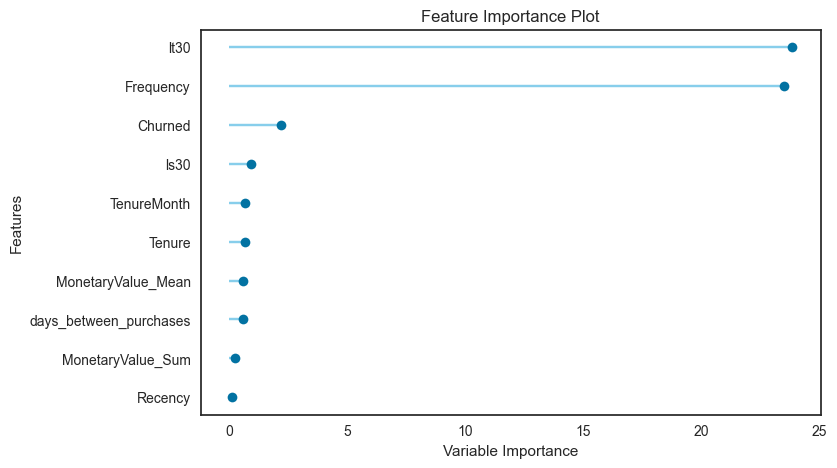

In [310]:
reg.plot_model(model,
              plot='feature')

#### Прогнозування

In [311]:
reg_pred = reg.predict_model(model, ml_segmentation(df_eu, pd.to_datetime('2011-12-01'))).rename({'prediction_label':'Pred_90D'}, axis=1)
# Оскільки всі повернення будуть враховані в подальшому розрахунку LTV й модель навчалась на невід'ємних значеннях -
# всі негативні значення зміню на нулі.
reg_pred['Pred_90D'] = reg_pred['Pred_90D'].apply(lambda x: 0 if x < 0 else x)
reg_pred.head()

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  \
0     12347.0       31          6        2874.260010          479.043335   
1     12348.0       67          4         210.199997           52.549999   
2     12349.0       10          1        1145.349976         1145.349976   
3     12350.0      302          1         334.399994          334.399994   
4     12352.0       28          7        1505.739990          215.105713   

   Tenure  Churned  TenureMonth  days_between_purchases  t30          s30  \
0     328        0           10               54.666668  1.0   524.289978   
1     283        0            9               70.750000  1.0    52.799999   
2       0        0            0                0.000000  1.0  1145.349976   
3       0        1            0                0.000000  1.0   334.399994   
4     260        0            8               37.142857  3.0   561.179993   

   lt30         ls30     Pred_90D  
0   0.0     0.000000  1022.725543  
1   1.0    40.000000     0.000000  
2   1.0  1145.349976     0.000000  
3   1.0   334.399994    22.205375  
4   1.0   231.729996   315.824576

### Basketing Analysis

In [415]:
# Беремо до уваги клієнтів, які принесуть > 1000$ у наступні 3 місяці.
cust_list = reg_pred['CustomerID'][reg_pred['Pred_90D']>1000].to_list()

In [416]:
# Цій групі клієнтів необхідно пропонувати товари з топу списку товарів,
# аби збільшувати продажі, оскільки вони їх споживають у великому об'ємі.
consumption_list = (df_eu
                    .query('CustomerID in @cust_list')
                    .groupby('Description')
                    .size()
                    .to_frame()
                    .set_axis(['count'], axis=1)
                    .sort_values('count', ascending=False)
                    .reset_index())
ba_sales = consumption_list[consumption_list['count']>150].Description.to_list()

In [417]:
ba_sales

['JUMBO BAG RED RETROSPOT',
 'LUNCH BAG RED RETROSPOT',
 'LUNCH BAG  BLACK SKULL.',
 'PARTY BUNTING',
 'SET OF 3 CAKE TINS PANTRY DESIGN ',
 'LUNCH BAG APPLE DESIGN',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'JUMBO BAG PINK POLKADOT',
 'LUNCH BAG PINK POLKADOT',
 'LUNCH BAG SPACEBOY DESIGN ',
 'LUNCH BAG CARS BLUE',
 'JUMBO SHOPPER VINTAGE RED PAISLEY',
 'JUMBO STORAGE BAG SUKI',
 'LUNCH BAG SUKI DESIGN ',
 'LUNCH BAG WOODLAND',
 'SET OF 4 PANTRY JELLY MOULDS',
 'PACK OF 72 RETROSPOT CAKE CASES',
 'JUMBO BAG VINTAGE LEAF',
 'JUMBO BAG APPLES',
 'REGENCY CAKESTAND 3 TIER',
 'ALARM CLOCK BAKELIKE RED ',
 'JAM MAKING SET PRINTED',
 'JUMBO BAG ALPHABET',
 'ALARM CLOCK BAKELIKE GREEN',
 'RED RETROSPOT CHARLOTTE BAG',
 'SET/5 RED RETROSPOT LID GLASS BOWLS',
 'SPOTTY BUNTING',
 'JUMBO BAG PINK VINTAGE PAISLEY',
 'JUMBO  BAG BAROQUE BLACK WHITE',
 'JUMBO BAG STRAWBERRY',
 'LUNCH BAG VINTAGE LEAF DESIGN',
 'RECIPE BOX PANTRY YELLOW DESIGN',
 'SPACEBOY LUNCH BOX ',
 'SET/20 RED RETROSPOT PAPER NA

In [418]:
# Аби збільшувати профіт з продажів - тиснемо на реалізацію цих товарів для топової групи клієнтів.
profit_list = (df_eu
                .query('CustomerID in @cust_list')
                .groupby('Description', as_index=False)
                .TotalSum
                .sum()
                .sort_values('TotalSum', ascending=False))
ba_prof = profit_list[profit_list['TotalSum']>2500].Description.to_list()

In [419]:
ba_prof

['JUMBO BAG RED RETROSPOT',
 'PARTY BUNTING',
 'LUNCH BAG RED RETROSPOT',
 'REGENCY CAKESTAND 3 TIER',
 'JUMBO BAG PINK POLKADOT',
 'JUMBO SHOPPER VINTAGE RED PAISLEY',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'JUMBO BAG VINTAGE LEAF',
 'JUMBO STORAGE BAG SUKI',
 'LUNCH BAG APPLE DESIGN',
 'SET OF 3 CAKE TINS PANTRY DESIGN ',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'JUMBO BAG APPLES',
 'LUNCH BAG PINK POLKADOT',
 'ALARM CLOCK BAKELIKE RED ',
 'JAM MAKING SET PRINTED',
 'LUNCH BAG  BLACK SKULL.',
 'ALARM CLOCK BAKELIKE GREEN',
 'SPOTTY BUNTING',
 'JUMBO BAG ALPHABET',
 'SET OF 3 REGENCY CAKE TINS',
 'LUNCH BAG SPACEBOY DESIGN ',
 'JUMBO BAG VINTAGE DOILY ',
 'JUMBO BAG PINK VINTAGE PAISLEY',
 'LUNCH BAG WOODLAND',
 'LUNCH BAG SUKI DESIGN ',
 'LUNCH BAG CARS BLUE',
 'ROSES REGENCY TEACUP AND SAUCER ',
 'JUMBO BAG STRAWBERRY',
 'GIN + TONIC DIET METAL SIGN',
 'SPACEBOY LUNCH BOX ',
 'JUMBO  BAG BAROQUE BLACK WHITE',
 'JAM MAKING SET WITH JARS',
 'RED TOADSTOOL LED NIGHT LIGHT']

In [420]:
# Беру до уваги товари, які продються найкраще й приносять найбільшу кількість грошей.
# Для цієї групи товарів я буду проводити BA.
ba_list = list(set(ba_sales).intersection(set(ba_prof)))
print(ba_list)

['ALARM CLOCK BAKELIKE GREEN', 'LUNCH BAG  BLACK SKULL.', 'ALARM CLOCK BAKELIKE RED ', 'WHITE HANGING HEART T-LIGHT HOLDER', 'SPACEBOY LUNCH BOX ', 'LUNCH BAG WOODLAND', 'JUMBO BAG PINK VINTAGE PAISLEY', 'LUNCH BAG CARS BLUE', 'LUNCH BAG APPLE DESIGN', 'JUMBO BAG ALPHABET', 'JUMBO BAG PINK POLKADOT', 'SET OF 3 REGENCY CAKE TINS', 'JUMBO STORAGE BAG SUKI', 'JUMBO BAG STRAWBERRY', 'SET OF 3 CAKE TINS PANTRY DESIGN ', 'JUMBO BAG VINTAGE LEAF', 'SPOTTY BUNTING', 'ROSES REGENCY TEACUP AND SAUCER ', 'PARTY BUNTING', 'JUMBO SHOPPER VINTAGE RED PAISLEY', 'LUNCH BAG PINK POLKADOT', 'LUNCH BAG SUKI DESIGN ', 'JUMBO  BAG BAROQUE BLACK WHITE', 'JUMBO BAG RED RETROSPOT', 'GIN + TONIC DIET METAL SIGN', 'REGENCY CAKESTAND 3 TIER', 'JUMBO BAG APPLES', 'JAM MAKING SET PRINTED', 'LUNCH BAG SPACEBOY DESIGN ', 'LUNCH BAG RED RETROSPOT']


In [421]:
# BA Dataset
ba_df = df_eu[df_eu['Description'].isin(ba_list)]

In [423]:
ba_df.to_csv("C:\\Users\\ASUS-X515EP\\Desktop\\Data\\df\\ba_df.csv")

### Work Process

In [424]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import re

In [425]:
# Беремо до уваги придбання найкращих клієнтів.
df_ba = df_eu.query('CustomerID in @cust_list')
df_ba.Description = df_ba.Description.astype('string')
df_ba.sample(2)

InvoiceNo StockCode                     Description  Quantity  \
329944    565859     22090         PAPER BUNTING RETROSPOT         6   
300906    563216     21389  IVORY HANGING DECORATION  BIRD         1   

       InvoiceDate  UnitPrice  CustomerID         Country  First_Month  \
329944  2011-09-07   2.949219     16818.0  United Kingdom            0   
300906  2011-08-14   0.850098     17841.0  United Kingdom            0   

        Last_Month  Region  TotalSum  
329944           0  Europe     17.70  
300906           0  Europe      0.85

In [426]:
# Обробка перед початком роботи
df_ba['Description'] = df_ba['Description'].str.strip(' .')

In [427]:
transactions_df = df_ba.groupby('InvoiceNo').agg({'Description': ';'.join})
transactions = transactions_df['Description'].apply(lambda x: x.split(';'))
transactions = list(transactions)

In [428]:
encoder = TransactionEncoder().fit(transactions)
onehot = encoder.transform(transactions)
onehot = pd.DataFrame(onehot, columns = encoder.columns_)

In [429]:
# Беремо комбінацію, яка зустрічається досить часто
frequent_itemsets = fpgrowth(onehot, 
                           min_support=0.008,
                           use_colnames=True)

rules = association_rules(
   frequent_itemsets,
   metric='confidence',
   min_threshold=0.5)

In [430]:
# Функція, яка шукає в "consequents" ті значення, що є в ba_list. 
# Тобто шукаємо продукти, які стимулюють продаж популярних і надійних товарів, що буде підвищувати шанс на додаткову покупку.
# Також ми знаємо, що ці продукти приносять найбільшу вигоду бізнесу - тому треба для них знаходити шляхи максимального поширення.
def contains_value_from_set(tup, my_set):
    return any(value in my_set for value in tup)

rules = rules[rules['consequents'].apply(lambda x: contains_value_from_set(x, ba_list))]

In [431]:
patterns = [r'.*JUMBO\s*.*BAG\b', r'.*LUNCH\s*.*BAG\b', 
            r'.*ALARM\s*.*CLOCK\b', r'.*HEART\s*.*T-LIGHT\b']

# Функція, яка вишукує однаковий тип товарів в одному рядку DF
def has_similar_words_in_both_columns(row):
    for pattern in patterns:
        if re.search(pattern, str(row['antecedents']), re.IGNORECASE) and re.search(pattern, str(row['consequents']), re.IGNORECASE):
            return True
    return False

# Застосовуємо функцію до кожного рядка DF
rules['has_similar'] = rules.apply(has_similar_words_in_both_columns, axis=1)

# Виключаємо рядки, де є схожі слова одночасно в обох колонках
filtered_df = rules[~rules['has_similar']].drop(columns=['has_similar'])

#### Пари для стимулювання продаж.

In [432]:
# Якщо у кошику спосерігається комбінації "Antecedents" - можна клієнту пропонувати відповідні товари "Consequents"
# за зниженою ціною, аби підвищити об'єм продаж та прибуток. 
for i, row in filtered_df.iterrows():
    print('Antecedents:', list(row.antecedents))
    print('    Consequents:', list(row.consequents))

Antecedents: ['WOODEN PICTURE FRAME WHITE FINISH', 'WOOD S/3 CABINET ANT WHITE FINISH']
    Consequents: ['WHITE HANGING HEART T-LIGHT HOLDER']
Antecedents: ['JUMBO STORAGE BAG SUKI', 'LUNCH BAG RED RETROSPOT', 'JUMBO BAG PINK POLKADOT']
    Consequents: ['JUMBO SHOPPER VINTAGE RED PAISLEY']
Antecedents: ['JUMBO STORAGE BAG SUKI', 'JUMBO SHOPPER VINTAGE RED PAISLEY', 'JUMBO BAG PINK POLKADOT']
    Consequents: ['LUNCH BAG RED RETROSPOT']
Antecedents: ['JUMBO STORAGE BAG SUKI', 'JUMBO BAG RED RETROSPOT']
    Consequents: ['JUMBO SHOPPER VINTAGE RED PAISLEY']
Antecedents: ['JUMBO STORAGE BAG SUKI', 'JUMBO BAG PINK POLKADOT']
    Consequents: ['JUMBO SHOPPER VINTAGE RED PAISLEY']
Antecedents: ['JUMBO STORAGE BAG SUKI', 'JUMBO BAG RED RETROSPOT', 'JUMBO BAG PINK POLKADOT']
    Consequents: ['JUMBO SHOPPER VINTAGE RED PAISLEY']
Antecedents: ['JUMBO STORAGE BAG SUKI', 'JUMBO BAG PINK VINTAGE PAISLEY']
    Consequents: ['JUMBO SHOPPER VINTAGE RED PAISLEY']
Antecedents: ['JUMBO STORAGE BAG SUK

### Clustering

In [433]:
clust_eu = seg_eu.merge(reg_pred[['CustomerID', 'Pred_90D']],
                       on='CustomerID',
                       how='left').dropna()

# Для аналізу ці показники не є дуже важливими
clust_eu = clust_eu.drop(['TenureMonth'], axis=1)

In [434]:
s = clust.setup(clust_eu, 
                normalize = True,
                use_gpu=True,
                n_jobs=-1,
                verbose=False,
                session_id=1100)

In [435]:
# Беру ієрархінчну кластеризацію.
hierachy = clust.create_model('hclust', 
                              num_clusters=5)

In [ ]:
clust.save_model(hierachy, 'clust')

In [ ]:
clust.load_model('clust')

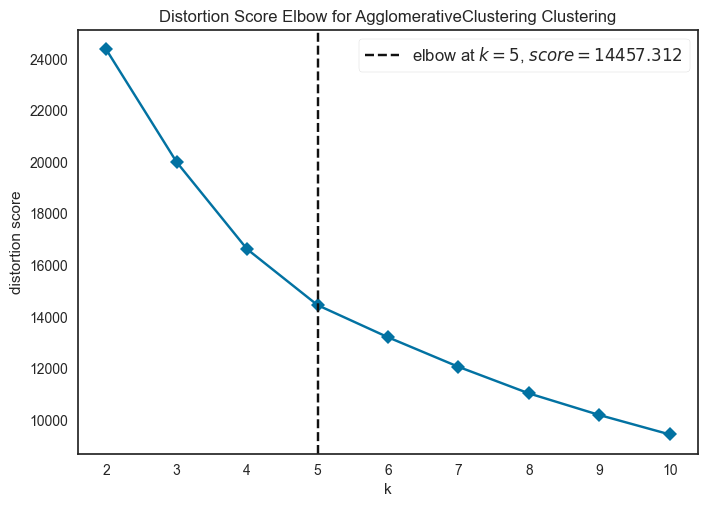

In [436]:
# Оцінка кількості необхідних кластерів, використовуючи ієрархічну кластеризацію
# 5 кластери є оптимальним вибором
clust.plot_model(hierachy, plot = 'elbow')

In [439]:
# Візуалізація розподілу кластерів.
clust.plot_model(hierachy, 
                 plot='tsne')

In [517]:
clust_pred_eu = clust.assign_model(hierachy)
clust_pred_eu.head()

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  \
0     12347.0        2          7        3099.080078          442.725708   
1     12348.0       75          4         210.199997           52.549999   
2     12349.0       18          1        1145.349976         1145.349976   
3     12350.0      310          1         334.399994          334.399994   
4     12352.0       36          7        1505.739990          215.105713   

   Tenure  Churned     Pred_90D    Cluster  
0     365        0  1022.725525  Cluster 1  
1     283        0     0.000000  Cluster 1  
2       0        0     0.000000  Cluster 0  
3       0        1    22.205376  Cluster 3  
4     260        0   315.824585  Cluster 1

In [518]:
clust_pred_eu.groupby('Cluster').mean()

CustomerID     Recency   Frequency  MonetaryValue_Sum  \
Cluster                                                              
Cluster 0  15087.628906   61.806411    1.888121         547.180603   
Cluster 1  15531.298828   38.592313    5.863264        1450.682617   
Cluster 2  14647.250000    1.750000  148.000000       42791.203125   
Cluster 3  15347.554688  267.972873    1.440197         304.272675   
Cluster 4  15122.165039   11.764706   27.200000        6481.037598   

           MonetaryValue_Mean      Tenure   Churned     Pred_90D  
Cluster                                                           
Cluster 0          276.285583   43.451288  0.000629    60.490849  
Cluster 1          249.463043  261.248267  0.000000   231.076782  
Cluster 2          301.050507  370.000000  0.000000  7384.160156  
Cluster 3          217.587952   19.979038  1.000000    58.951439  
Cluster 4          290.310944  342.070588  0.011765  1664.837524

In [519]:
clust_pred_eu['Cluster'] = clust_pred_eu['Cluster'].replace({'Cluster 0':'Bronze',
                                                            'Cluster 1':'Silver',
                                                            'Cluster 2':'Diamond', 
                                                            'Cluster 3':'Dead',
                                                            'Cluster 4':'Gold'}) 

In [520]:
eu_clust_agg = clust_segm(clust_pred_eu)
eu_clust_agg

Recency  Frequency  MonetaryValue_Sum_mean  Pred_90D_mean  Tenure  \
Cluster                                                                      
Bronze      61.8        1.9              547.200012      60.500000    43.5   
Dead       268.0        1.4              304.299988      59.000000    20.0   
Diamond      1.8      148.0            42791.199219    7384.200195   370.0   
Gold        11.8       27.2             6481.000000    1664.800049   342.1   
Silver      38.6        5.9             1450.699951     231.100006   261.2   

         Customers  
Cluster             
Bronze        1591  
Dead           811  
Diamond          4  
Gold            85  
Silver        1587

In [521]:
clust_pred_eu = clust_pred_eu.merge(df_eu[['CustomerID', 'Country']], 
                                    how='left', on='CustomerID').drop_duplicates()
clust_pred_eu.sample(5)

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  \
172903     15167.0      320          1         158.800003          158.800003   
182953     15381.0      268          1         143.100006          143.100006   
192244     15540.0       11          1         185.220001          185.220001   
214795     15958.0       74          1          60.900002           60.900002   
305596     17600.0       17          1         147.630005          147.630005   

        Tenure  Churned    Pred_90D Cluster         Country  
172903       0        1   35.593178    Dead  United Kingdom  
182953       0        1  188.294556    Dead  United Kingdom  
192244       0        0    0.000000  Bronze  United Kingdom  
214795       0        0   14.545291  Bronze  United Kingdom  
305596       0        0    1.573904  Bronze  United Kingdom

In [522]:
# LTV = current value + future value (3 month) 
# враховуємо 8.4% грошових втрат
clust_pred_eu['LTV'] = (clust_pred_eu['MonetaryValue_Sum'] + clust_pred_eu['Pred_90D']) * 0.916
clust_pred_eu.sample(5)

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  \
118292     14456.0        5          9        2895.860107          321.762207   
318818     17796.0       40          4         690.000000          172.500000   
108007     14267.0      162          3        1091.939941          363.980011   
250897     16681.0       77          5         455.739990           91.148003   
64903      13501.0      288          1         815.719971          815.719971   

        Tenure  Churned    Pred_90D Cluster         Country          LTV  
118292     137        0  422.036804  Silver  United Kingdom  3039.193604  
318818     329        0  127.818085  Silver  United Kingdom   749.121399  
108007      98        0   72.866776  Silver  United Kingdom  1066.963013  
250897     176        0  121.974426  Silver  United Kingdom   529.186401  
64903        0        1  774.542542    Dead     Switzerland  1456.680420

In [523]:
clust_pred_eu = clust_pred_eu.drop(['Churned', 'MonetaryValue_Mean'], axis=1)

In [525]:
clust_pred_eu.to_csv("C:\\Users\\ASUS-X515EP\\Desktop\\Data\\df\\df_clust.csv")

In [529]:
clust_eu = df_main[df_main['Region']=="Europe"].merge(clust_pred_eu[['CustomerID', 'Cluster']], on='CustomerID', how='left')
clust_eu.to_csv("C:\\Users\\ASUS-X515EP\\Desktop\\Data\\df\\df_eu.csv")

### LTV :)

In [448]:
# Агрегований LTV
df_ltv = df_main[
                (df_main['TotalSum'] > 0) & (df_main['TotalSum'] < 42.5)
                & (df_main['Quantity'] > 0) & (df_main['Quantity'] < 27.5)
                & (df_main['UnitPrice'] > 0)
                 ].copy()

seg_ltv = segmentation(df_ltv, max_date)
agg_ltv = agg_ltv(seg_ltv, "Europe") * 0.916

# Узагальнений LTV
print(f'LTV по палаті складає: {np.round(agg_ltv, 1)}$')

LTV по палаті складає: 3944.2$


In [450]:
# LTV отриманий з когорт
ltv_coh = LTV_coh(df_ltv) * 0.916
print(f"LTV, використовуючи когорти, складає: {ltv_coh:.2f}$")

LTV, використовуючи когорти, складає: 2809.12$


In [194]:
# Survival LTV
print(f'LTV та середнє життя клієнта за роботою Survival Curve складає відповідно: {suvr_eu_LTV.iloc[-1, -1]:.2f}$, {suvr_eu_LTV.iloc[-1, 0]:.0f} місяців.')

LTV та життя середнє життя клієнта за роботою Survival Curve складає відповідно: 5805.37$, 29 місяців.


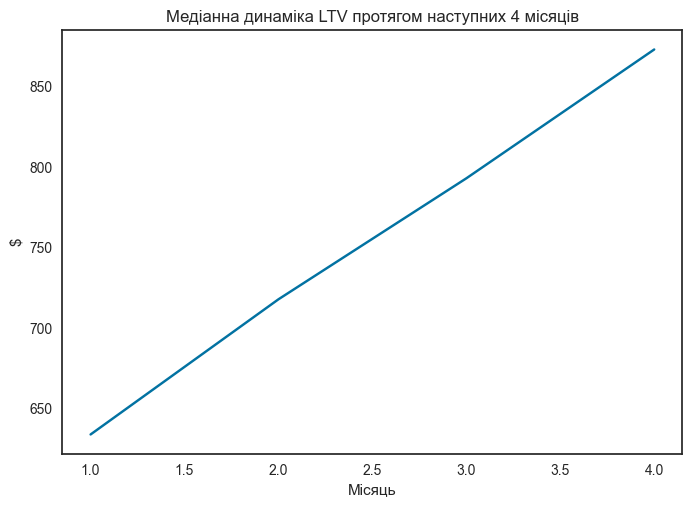

<Figure size 600x600 with 0 Axes>

In [476]:
# Аби прогнози агрегованого LTV були більш адекватними - візму медіану їх значень
plot_din(prob_eu_)

# З урахуванням того, що ця модель недооцінює значення того, скільки принесе звичайний юзер грошей за все своє життя, 
# але це значення не занадто велике - можно його використовувати як орієнтир для "порогу" динаміки майбутнього LTV.

In [477]:
# LTV за роботою ймовірнісної моделі
ltv_prob = prob_eu_['CLV_4month'].median()
print(f'На наступні 4 місяці можна очікувати такий медіанний прибуток з користувача: {ltv_prob:.2f}$')

На наступні 4 місяці можна очікувати такий медіанний прибуток з користувача: 873.01$


In [480]:
# LTV за роботою регресійної моделі
clust_df = clust_pred_eu
clust_df.sample(5)

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  \
222994     16091.0      154          2         315.059998          157.529999   
298185     17453.0       17          2         303.119995          151.559998   
305024     17593.0        3          5        2826.179932          565.236023   
262856     16823.0      227          1         358.380005          358.380005   
34454      12933.0       24          3         508.070007          169.356674   

        Tenure  Churned    Pred_90D Cluster         Country  
222994      44        0   65.952133  Bronze  United Kingdom  
298185      47        0   53.496277  Bronze  United Kingdom  
305024     349        0  927.812256  Silver  United Kingdom  
262856       0        1   10.405774    Dead  United Kingdom  
34454      259        0    0.000000  Silver  United Kingdom

In [483]:
# Розраховую LTV як сума значень середнього ltv по сегментам множене на частку цього сегменту в популяції.
ml_ltv_m = clust_df.groupby('Cluster', as_index=False).LTV.mean()
ml_ltv_f = clust_df.Cluster.value_counts(normalize=True)
ml_ltv = ml_ltv_m.merge(ml_ltv_f, on='Cluster')
ml_ltv['frac_ltv'] = ml_ltv['LTV'] * ml_ltv['proportion']

In [488]:
ltv = ml_ltv.frac_ltv.sum()
print(f"Оцінка LTV після роботи моделі на наступні 3 місяці складає: {ltv:.2f}$")

Оцінка LTV після роботи моделі на наступні 3 місяці складає: 1084.42$


## Seasonality exploration

Цей блок необхідний при подальшому вивченні тенденцій продаж у Tableau.

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
df_s = df_eu.groupby('InvoiceDate').TotalSum.sum()
df_s.head()

InvoiceDate
2010-12-01    19242.40
2010-12-02    22335.12
2010-12-03    11472.51
2010-12-05    20048.22
2010-12-06    17509.32
Name: TotalSum, dtype: float64

In [36]:
# Доповнюю датафрейм датами, які не зазначені у діапазоні та інтерполюю їх.
df_s = df_s.reindex(pd.date_range('2010-12-01', '2011-12-09', freq='D')).interpolate()

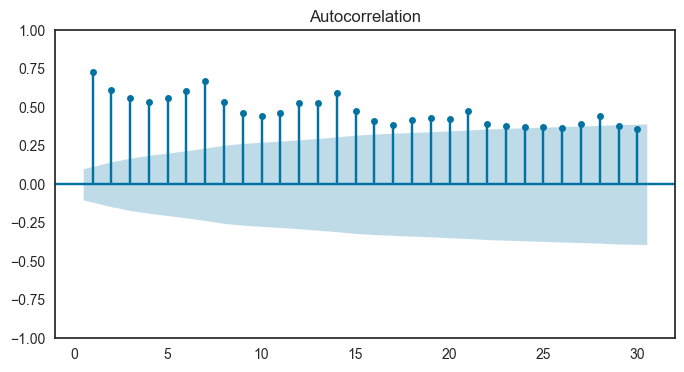

In [37]:
# Зображаю ACF для знаходження сезонності по днях.
fig, (ax1) = plt.subplots(1,1,figsize=(8,4))
plot_acf(df_s,
        lags=30,
        zero=False,
        ax=ax1)
plt.show()

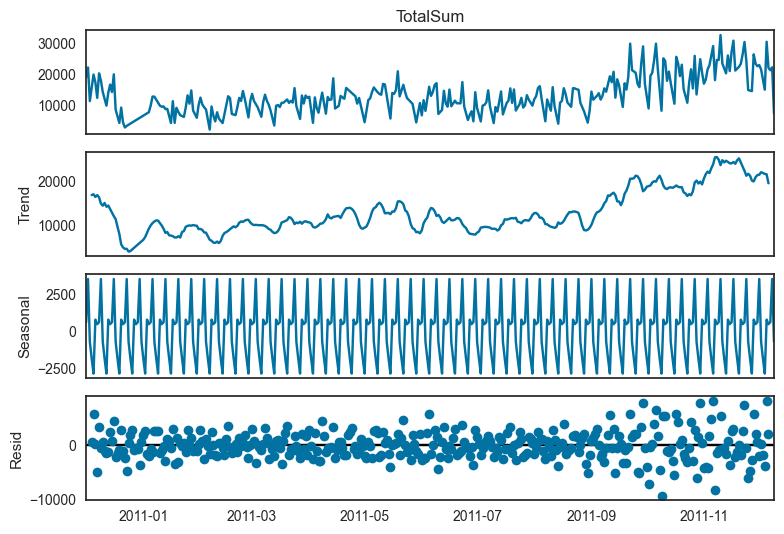

In [38]:
# З графіку вище можна побачити, що сезонність складає 7 днів. Що також можна побачити за деконпозицією нижче.
decomp = seasonal_decompose(df_s,
                            period=7)
decomp.plot()
plt.show()

# Додатковий аналіз

## Oceania

### Dataset

In [338]:
df_o = region_df(df_main, 'Oceania')
df_o.sample(2)

InvoiceNo StockCode                      Description  Quantity  ...    Country  First_Month   Region   TotalSum
244579    558536     22736      RIBBON REEL MAKING SNOWMEN         10  ...  Australia            1  Oceania  16.500000
244583    558536     85152  HAND OVER THE CHOCOLATE   SIGN         12  ...  Australia            1  Oceania  25.200001

[2 rows x 11 columns]

### Cohort

In [402]:
pivot_o = cohort_month(df_main, 'Oceania')[1]
pivot_o.head(1)

MonthIndex    1    2    3   4   5    6   7    8    9   10   11
CohortMonth                                                   
2010-12-01   2.0  1.0  1.0 NaN NaN  1.0 NaN  1.0  1.0 NaN  1.0

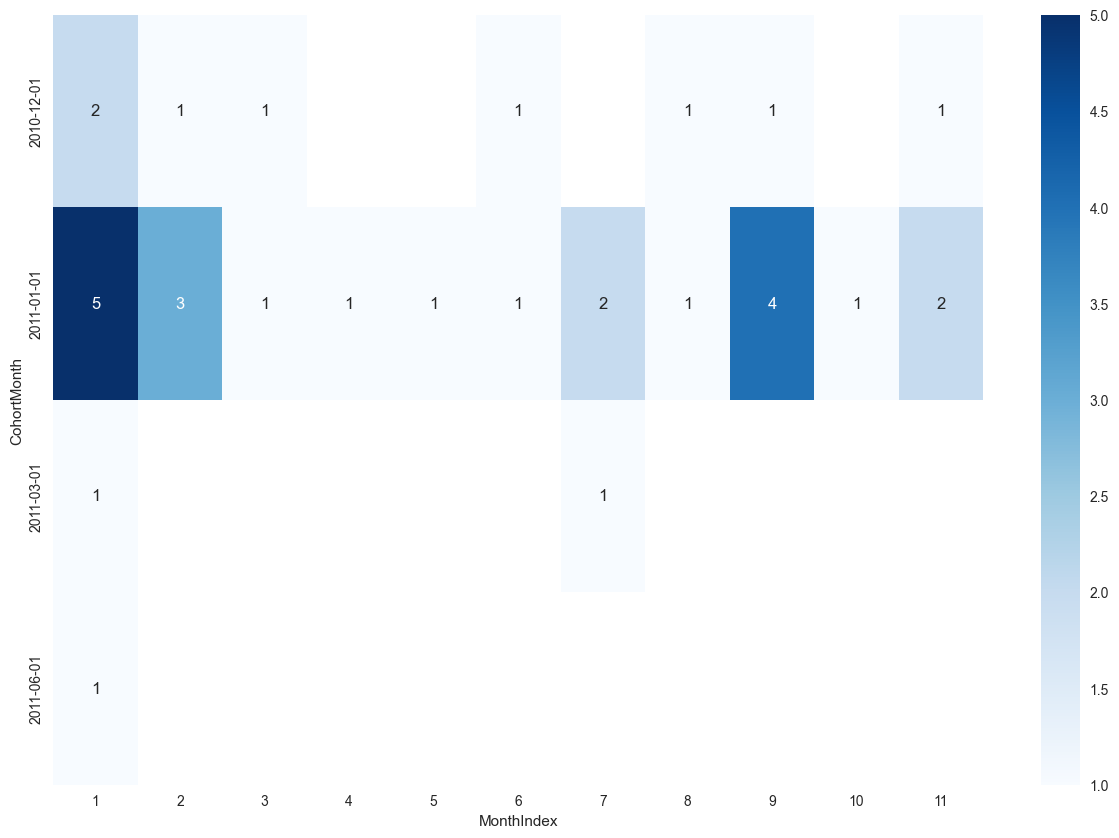

In [403]:
viz_cohort(pivot_o)

### Segmentation

In [434]:
seg_o = segmentation(df_o, max_date)

In [435]:
seg_o

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  Tenure  TenureMonth
0     12386.0      366          1         144.300003          144.300003       0            0
1     12388.0       15          6        1703.260010          283.876678     311           10
2     12393.0       72          4        1193.500000          298.375000     260            8
3     12415.0       36          8         819.250000          102.406250     301           10
4     12422.0       95          2         386.200012          193.100006     229            7
5     12424.0      162          2         273.520020          136.760010       0            0
6     12431.0       64         11        3048.830078          277.166382     309           10
7     12434.0       84          2         713.539978          356.769989     176            5
8     16321.0       72          5         267.450012           53.490002     251            8

In [437]:
print(f'Загальна кількість грошей за рік: {np.round(seg_o.MonetaryValue_Sum.sum())}$')

Загальна кількість грошей за рік: 8550.0$


### LTV

In [439]:
# Узагальнений LTV
ltv = np.round(agg_ltv(seg_o, "Oceania") * 0.916
print(f'LTV по палаті в Океанії складає: {ltv, 1)}$')

LTV по палаті в Океанії складає: 2803.6$


## Middle East

### Dataset

In [405]:
df_me = region_df(df_main, 'Middle East')
df_me.sample(2)

InvoiceNo StockCode                Description  Quantity  ...  Country  First_Month       Region   TotalSum
72987     542276     82600      NO SINGING METAL SIGN        12  ...  Lebanon            1  Middle East  25.200001
304857    563613     23209  LUNCH BAG DOILEY PATTERN         10  ...   Israel            1  Middle East  16.500000

[2 rows x 11 columns]

### Cohort

In [408]:
pivot_me = cohort_month(df_main, 'Middle East')[1]
pivot_me.head(1)

MonthIndex     1   6
CohortMonth         
2011-01-01   1.0 NaN

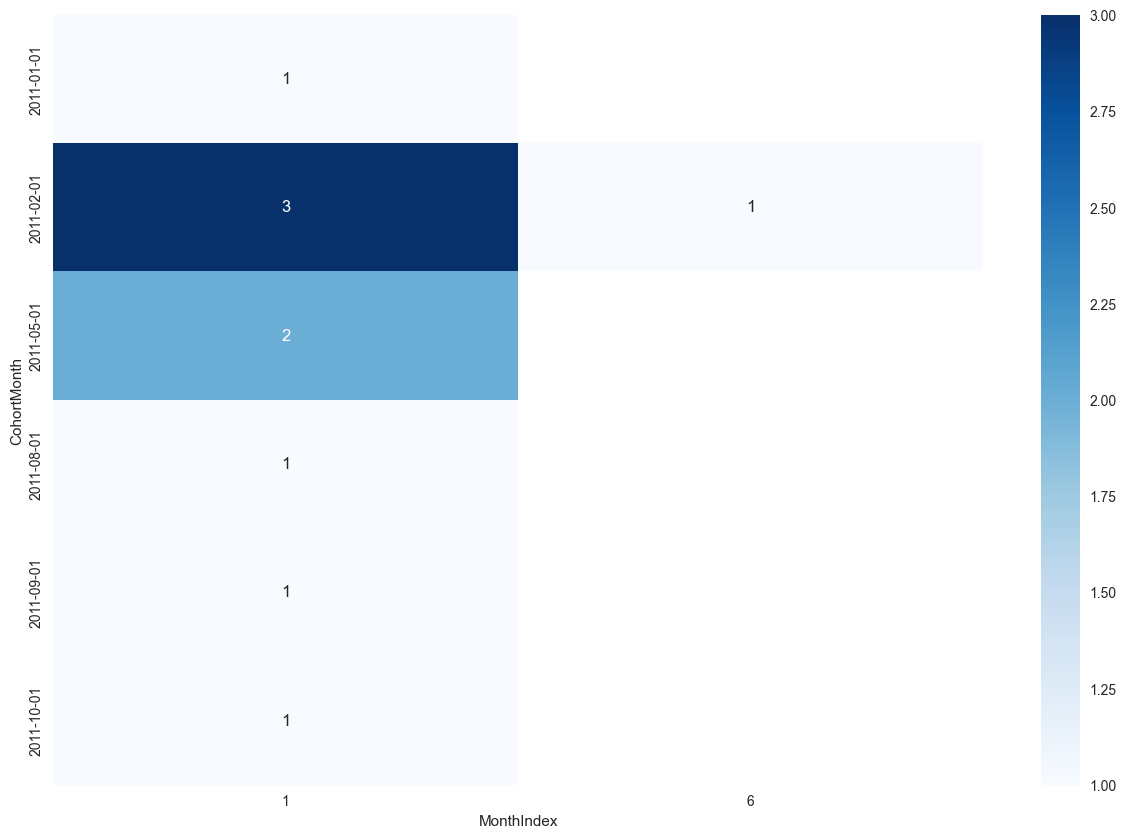

In [409]:
viz_cohort(pivot_me)

### Segmentation

In [420]:
seg_me = segmentation(df_me, max_date)
seg_me

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  Tenure  TenureMonth
0     12353.0      204          1          89.000000           89.000000       0            0
1     12355.0      214          1         264.399994          264.399994       0            0
2     12512.0       66          2         132.179993           66.089996       0            0
3     12565.0      288          1         145.919998          145.919998       0            0
4     12653.0      148          2         532.699951          266.349976     148            4
5     12688.0      113          1        2736.689941         2736.689941       0            0
6     12739.0       78          2         494.100006          247.050003      21            0
7     12764.0      316          1         741.330017          741.330017       0            0
8     17829.0      298          1         654.640015          654.640015       0            0

In [421]:
print(f'Загальна кількість грошей за рік: {np.round(seg_me.MonetaryValue_Sum.sum())}$')

Загальна кількість грошей за рік: 5791.0$


## North America

### Dataset

In [415]:
df_na = region_df(df_main, 'North America')
df_na.sample(2)

InvoiceNo StockCode                       Description  Quantity  ... Country  First_Month         Region   TotalSum
389378    570467     84991       60 TEATIME FAIRY CAKE CASES        24  ...     USA            1  North America  13.200000
119199    546533     21622  VINTAGE UNION JACK CUSHION COVER         4  ...  Canada            1  North America  19.799999

[2 rows x 11 columns]

### Cohort

In [416]:
pivot_na = cohort_month(df_main, 'North America')[1]
pivot_na.head(1)

MonthIndex     1   2   3
CohortMonth             
2011-03-01   1.0 NaN NaN

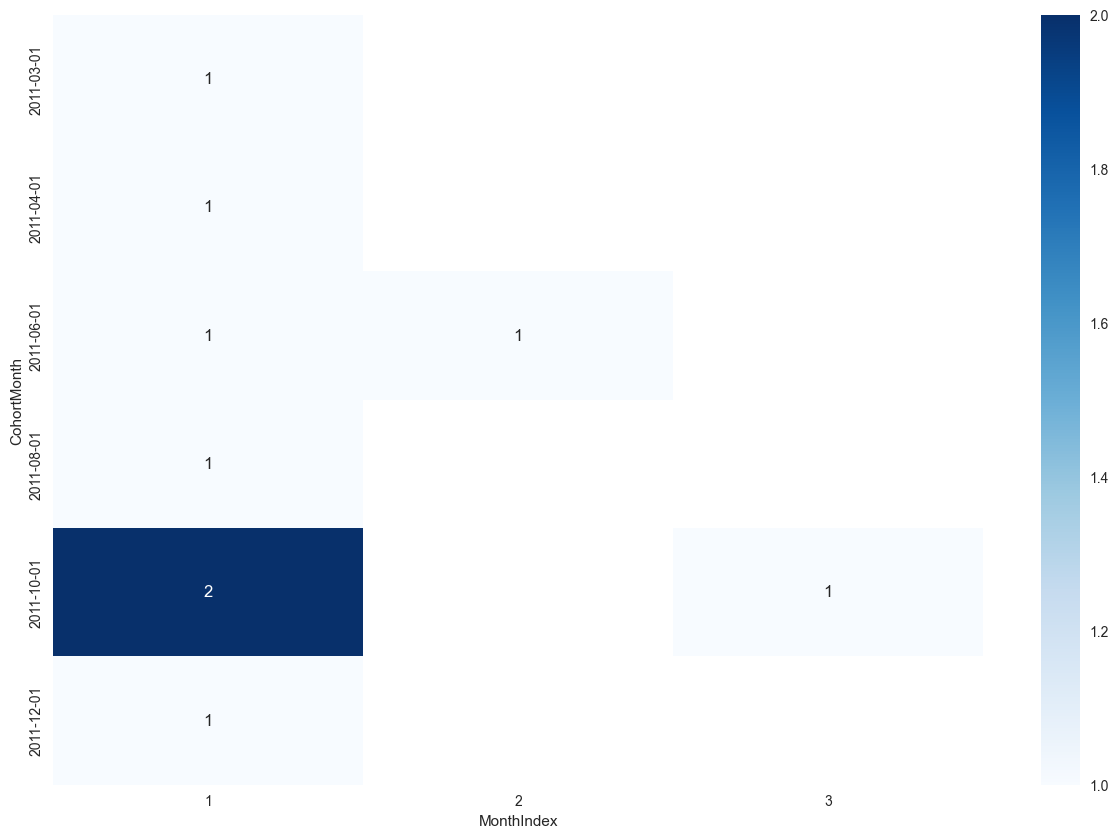

In [417]:
viz_cohort(pivot_na)

### Segmentation

In [419]:
seg_na = segmentation(df_na, max_date)
seg_na

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  Tenure  TenureMonth
0     12558.0        7          1         145.160004          145.160004       0            0
1     12607.0       60          1        1556.109985         1556.109985       0            0
2     12646.0        4          2         753.489990          376.744995      45            1
3     12733.0      234          1         276.850006          276.850006       0            0
4     15388.0      270          1         140.539993          140.539993       0            0
5     17444.0      151          2        1959.739990          979.869995      21            0
6     17844.0      106          1          51.560001           51.560001       0            0

In [422]:
print(f'Загальна кількість грошей за рік: {np.round(seg_na.MonetaryValue_Sum.sum())}$')

Загальна кількість грошей за рік: 4883.0$


## Asia

### Dataset

In [427]:
df_a = region_df(df_main, 'Asia')
df_a.sample(2)

InvoiceNo StockCode                         Description  Quantity  ...    Country  First_Month  Region TotalSum
81829    543179     22257              FELT FARM ANIMAL SHEEP         1  ...      Japan            1    Asia     1.25
70775    542102     21791  VINTAGE HEADS AND TAILS CARD GAME         12  ...  Singapore            1    Asia    15.00

[2 rows x 11 columns]

### Cohort

In [429]:
pivot_a = cohort_month(df_main, 'Asia')[1]
pivot_a.head(1)

MonthIndex    1   2    4    5   7    8   10
CohortMonth                                
2010-12-01   2.0 NaN  1.0  1.0 NaN  1.0 NaN

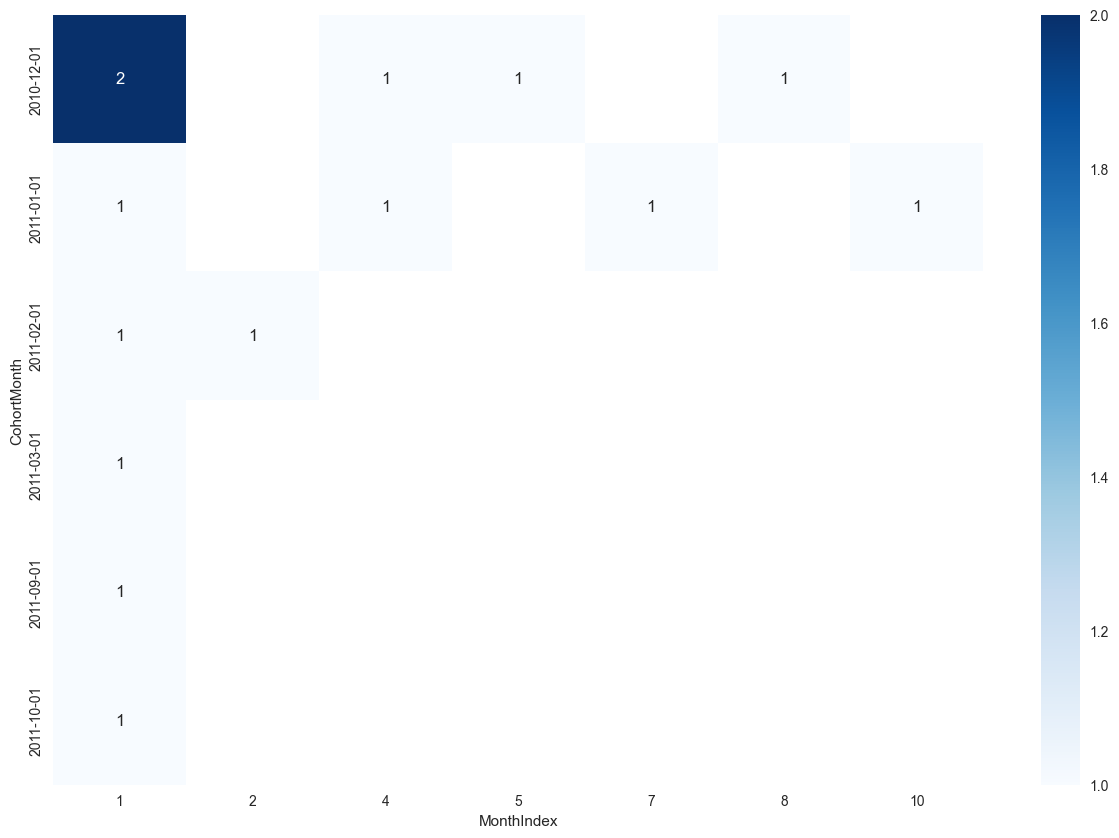

In [430]:
viz_cohort(pivot_a)

### Segmentation

In [433]:
seg_a = segmentation(df_a, max_date)
seg_a

CustomerID  Recency  Frequency  MonetaryValue_Sum  MonetaryValue_Mean  Tenure  TenureMonth
0     12744.0       56          4        2298.439941          574.609985     262            8
1     12753.0      135          4         106.080002           26.520000     227            7
2     12754.0      277          2          61.619999           30.809999      31            1
3     12755.0      280          1          17.549999           17.549999       0            0
4     12756.0       86          1          50.879997           50.879997       0            0
5     12763.0      369          1         260.079987          260.079987       0            0
6     12812.0       44          1         229.639999          229.639999       0            0

In [438]:
print(f'Загальна кількість грошей за рік: {np.round(seg_a.MonetaryValue_Sum.sum())}$')

Загальна кількість грошей за рік: 3024.0$


In [440]:
# Узагальнений LTV
ltv = agg_ltv(seg_a, "Oceania") * 0.916
print(f'LTV по палаті в Азії складає: {np.round(ltv, 1)}$')

LTV по палаті в Азії складає: 595.0$
